In [1]:
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
#Import the finite market model functionality from the PortfolioBase notebook
%pip install nbformat
%run PortfolioBase.ipynb


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import csv
from contextlib import closing
import csv
from codecs import iterdecode

from sklearn.cluster import AgglomerativeClustering
from scipy.stats import wasserstein_distance


import matplotlib.pyplot as plt

In [68]:

file = open("FTSE100.tickers")
iter = csv.reader(file, delimiter='\n')

tickers = []
train_stocks = {}
validate_stocks = {}
test_stocks = {}

for ticker in iter:
    tickers=tickers+[ticker[0].split(".")[0]]

for tick in tickers:
    stockData = pd.read_csv(f"HistoricPrices/{tick}.csv", header = 0, names=("Day", "Price"))
    train_stocks[tick], further_stocks = np.split(stockData, [int(.80 *len(stockData))])
    validate_stocks[tick], test_stocks[tick] = np.split(further_stocks, [int(.50 *len(further_stocks))])

#Split such that we are considering intervals of time rather than random times 
print(validate_stocks)
print(len(validate_stocks["BA"]))
print(len(test_stocks["BA"]))


C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
C:\Users\james\AppData\Roaming\Python\Python312\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return b

{'III':        Day        Price
1008  1008  1315.143799
1009  1009  1317.643066
1010  1010  1313.144409
1011  1011  1311.144897
1012  1012  1314.144043
...    ...          ...
1129  1129  1954.970459
1130  1130  1935.975708
1131  1131  1959.469360
1132  1132  1954.970459
1133  1133  1999.458496

[126 rows x 2 columns], 'ADM':        Day        Price
1008  1008  2034.853394
1009  1009  2012.123169
1010  1010  2002.240356
1011  1011  1978.521851
1012  1012  1969.627319
...    ...          ...
1129  1129  2312.427246
1130  1130  2294.524658
1131  1131  2361.162354
1132  1132  2351.216309
1133  1133  2379.064941

[126 rows x 2 columns], 'AAF':        Day       Price
896    896  114.161636
897    897  113.014282
898    898  111.580086
899    899  107.468742
900    900  110.337128
...    ...         ...
1003  1003  114.161636
1004  1004  111.281288
1005  1005  110.003326
1006  1006  109.216888
1007  1007  110.101631

[112 rows x 2 columns], 'AAL':        Day        Price
1008  1008  3155.378

In [9]:
def estimateClassProbsFromSample(preds,classes):
    probs = []
    for i in range(classes):
        probs.append(np.count_nonzero(preds == float(i))/len(preds))
    return probs

#Use the mean element as a representitive of the cluster (could have also have used the median)
def calculateCentralClassElement(x, preds, classes):
    sizes = {x:0 for x in range(classes)}
    cumulative = {x:0 for x in range(classes)}
    for i in range(len(x)):
        assignedClass = int(preds[i])
        sizes[assignedClass] += 1
        cumulative[assignedClass] += x[i]
    return [cumulative[i]/sizes[i] for i in range(classes)]

In [16]:
def naiveFitMultinomialStock(stocksData, ticker : str, classes : int, linkage = "ward"):

    data = stocksData[ticker].diff().dropna()["Price"].to_numpy()

    clust = AgglomerativeClustering(classes ,linkage=linkage)
    clust.fit(data.reshape(-1, 1))
    
    preds = clust.fit_predict(data.reshape(-1, 1))

    meanJumps = calculateCentralClassElement(data,preds,classes)
    jumpProbs = estimateClassProbsFromSample(preds,classes)

    initial = stocksData[ticker].dropna()["Price"][1]
    model = MultinomialStock(f"{ticker} {str(classes)}-jump",initial,meanJumps, jumpProbs)
    return model

In [26]:
def plotStockPrice(ticker, jumpClasses = 10, realisations = 5):
    stock = naiveFitMultinomialStock(stocks,ticker,jumpClasses)
    runs = []
    for h in range(realisations):
        values = []
        for i in range(len(stocks[ticker])):
            values.append(stock.value)
            stock.evolve()
        stock.reset()
        runs.append(values)

    for values in runs:
        plt.plot(values)

    plt.title(f"The price over time of {str(realisations)} multinomial({str(jumpClasses)}-class) model realisations for {stock}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()
    for values in runs:
        plt.plot(values - stocks[ticker]["Price"])

    plt.title(f"The difference in price between the fitted model and actual {stock} stock price")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

In [27]:
# Accessed from https://scikit-learn.org/stable/_downloads/4cb9ca0dda94124c7cb99dcaae983dab/plot_agglomerative_dendrogram.py
# Authors: Mathew Kallada, Andreas Mueller
# License: BSD 3 clause
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [30]:
def plotJumpClustering(ticker, jumpClasses = 10, linkage = "ward"):
    data = stocks[ticker].diff().dropna()["Price"].to_numpy()[1:]
    clust = AgglomerativeClustering(jumpClasses,linkage=linkage)
    reshapedData = data.reshape(-1, 1)
    clust.fit(reshapedData)

    preds = clust.fit_predict(reshapedData)

    plt.scatter(preds, data)
    plt.xlabel("Clustering")
    plt.ylabel("Price")
    plt.title("The ....")
    plt.show()

    fullClustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    fullClustering.fit(reshapedData)
    plot_dendrogram(fullClustering, truncate_mode="level", p=7)
    plt.title(f"A dendrogram to show the formation of clusters for {ticker}")
    plt.show()

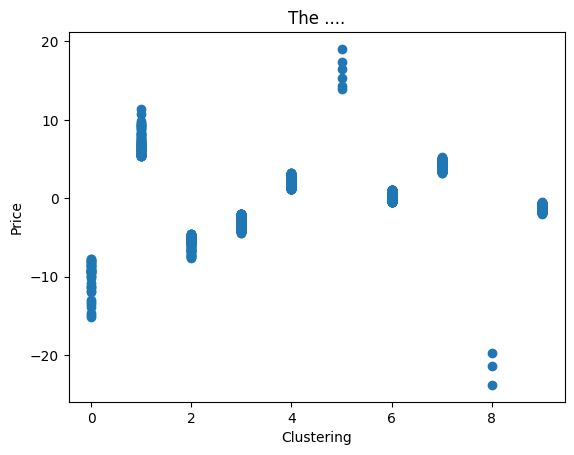

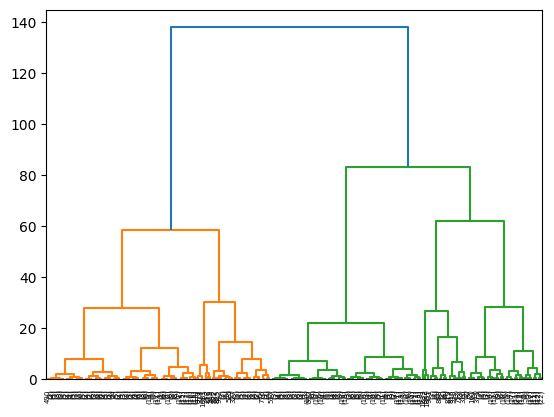

In [31]:
plotJumpClustering("NWG")

In [20]:
ftse100 = []
for tick in tickers:
    ftse100.append(naiveFitMultinomialStock(stocks, tick, 6))

ftse100Market = Market(ftse100)
for i in range(len(stocks["NWG"])):
    ftse100Market.evolve()


ftse100_10jump = []
for tick in tickers:
    ftse100_10jump.append(naiveFitMultinomialStock(stocks, tick, 10))

ftse100_10jumpMarket = Market(ftse100_10jump)
for i in range(len(stocks["NWG"])):
    ftse100_10jumpMarket.evolve()


# Evaluation

- Comparision of Wasserstein distances (model vs sample), rank order the stocks.

- Comparision of variances (100 runs, variance over each run)

- Comparision of market returns??

- Autocorrelation of sample (models at the momement have zero autocorrelation)

In [21]:
for i in range(len(tickers)):
    wd = someDist(np.array(ftse100Market.history)[:,i], stocks[tickers[i]]["Price"])

NameError: name 'someDist' is not defined

[-4.66597755e-01 -4.63347952e-01 -4.47474643e-01 -4.19082193e-01
 -4.14146392e-01 -4.06692790e-01 -4.02982540e-01 -3.86368624e-01
 -3.73109152e-01 -3.41185829e-01 -3.07560481e-01 -2.35454393e-01
 -1.17194811e-01 -9.25923867e-02 -8.27492294e-02 -7.63599839e-02
 -6.15615411e-02 -5.83095014e-02 -5.20441712e-02 -5.17309062e-02
 -4.98580445e-02 -4.91959608e-02 -4.75553473e-02 -3.78966276e-02
 -3.68297472e-02 -3.67048944e-02 -3.58646682e-02 -3.56957692e-02
 -3.18271179e-02 -3.16098782e-02 -2.94885223e-02 -2.87518813e-02
 -2.79025269e-02 -2.65432926e-02 -2.61221043e-02 -2.60261980e-02
 -2.56911266e-02 -2.54688743e-02 -2.50506642e-02 -2.36160956e-02
 -2.26275728e-02 -2.14813912e-02 -2.12913489e-02 -2.11760687e-02
 -2.03223965e-02 -1.83212681e-02 -1.54558682e-02 -1.39928095e-02
 -1.29869822e-02 -1.11344537e-02 -1.11328289e-02 -1.10071317e-02
 -1.05699252e-02 -1.00753653e-02 -9.88440020e-03 -7.98465016e-03
 -6.20201968e-03 -6.14297815e-03 -5.90140342e-03 -4.50484564e-03
 -4.40194047e-03 -1.62307

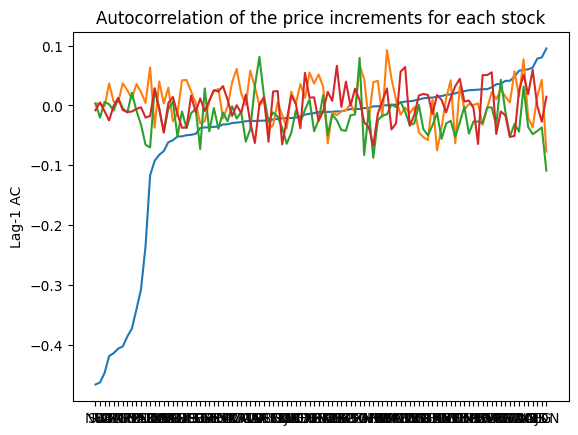

In [61]:
#Issues with scale??
acf = []

lags = 5
for i in range(len(tickers)):
    realSample = stocks[tickers[i]]["Price"].diff().dropna()[1:]
    diffACF = []
    for h in range(1,lags):
        diffACF.append(realSample.autocorr(lag=h))
    acf.append([np.array(diffACF), tickers[i]])

def distSort(e):
    return float(e[0][0])

acf.sort(key=distSort)
sTickers = []
sDistances = []
sDist2 = []
for item in acf:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.title("Autocorrelation of the price increments for each stock")
plt.ylabel("Lag-1 AC")
print(np.array(sDistances)[:,0])

for i in range(lags-1):
    plt.plot(sTickers, np.array(sDistances)[:,i])

print(sTickers[30:40])
print(sDistances[60:70])

['LLOY', 'VOD', 'CNA', 'AAF', 'BT-A', 'TSCO', 'TW', 'JD', 'CTEC', 'MNG', 'NWG', 'SBRY', 'LGEN', 'HLN', 'BARC', 'MKS', 'RR', 'KGF', 'AV', 'SMDS', 'GLEN', 'HSBA', 'BME', 'PHNX', 'SDR', 'BP', 'IAG', 'FCIT', 'BEZ', 'MRO', 'AUTO', 'RTO', 'RMV', 'BDEV', 'INF', 'HWDN', 'STAN', 'LAND', 'UU', 'SGE', 'FRAS', 'BA', 'RS1', 'NG', 'PSON', 'SGRO', 'GSK', 'SMT', 'III', 'UTG', 'WPP', 'IMB', 'SSE', 'FRES', 'SMIN', 'STJ', 'SN', 'IMI', 'REL', 'MNDI', 'ENT', 'BNZL', 'SHEL', 'WEIR', 'BRBY', 'PRU', 'ANTO', 'PSH', 'HLMA', 'ABF', 'BATS', 'CPG', 'CCH', 'HIK', 'HL', 'SVT', 'ADM', 'DGE', 'OCDO', 'EXPN', 'DPLM', 'AAL', 'SKG', 'ULVR', 'WTB', 'ITRK', 'EDV', 'BKG', 'RKT', 'AHT']
[0.20242438604054297, 0.4135782328869545, 0.5456364785395411, 0.5520334559595561, 0.6524976511807775, 0.6772057031513452, 0.698542370503995, 0.8650269457496438, 0.867127189562935, 0.9008744464010747, 0.9491944673545036, 0.9628993742491381, 1.0290396737608547, 1.036470918873159, 1.0859631914633985, 1.1330396905867168, 1.1911879809614323, 1.199

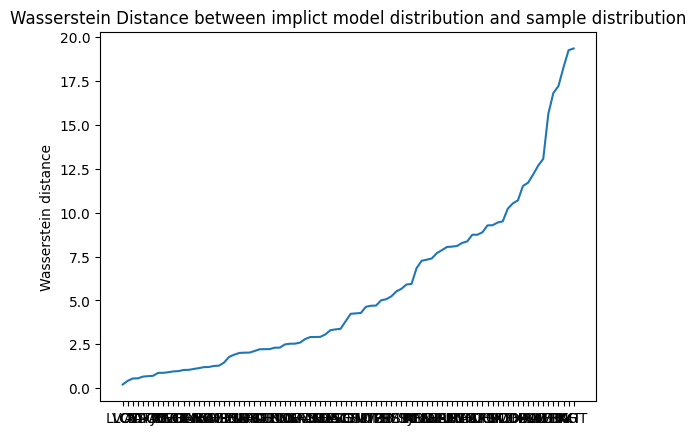

In [25]:
#Issues with scale??
wd = []
for i in range(len(tickers)):
    stock = ftse100Market.assets[i]
    realSample = np.array(stocks[tickers[i]]["Price"].diff().dropna()[1:])
    wd.append([wasserstein_distance(u_values=stock.values, v_values=realSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(realSample))/len(realSample)), tickers[i]])

def distSort(e):
    return float(e[0])

wd.sort(key=distSort)
sTickers = []
sDistances = []
for item in wd[:90]:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.title("Wasserstein Distance between implict model distribution and sample distribution")
plt.ylabel("Wasserstein distance")
plt.plot(sTickers, sDistances)
print(sTickers)
print(sDistances)

['LLOY', 'VOD', 'CNA', 'AAF', 'BT-A', 'TSCO', 'TW', 'JD', 'MNG', 'CTEC', 'SBRY', 'NWG', 'LGEN', 'HLN', 'BARC', 'MKS', 'RR', 'KGF', 'SMDS', 'AV', 'GLEN', 'HSBA', 'BME', 'PHNX', 'SDR', 'BP', 'IAG', 'FCIT', 'BEZ', 'MRO', 'RTO', 'AUTO', 'BDEV', 'INF', 'RMV', 'HWDN', 'STAN', 'LAND', 'UU', 'SGE', 'FRAS', 'BA', 'RS1', 'NG', 'PSON', 'SGRO', 'GSK', 'SMT', 'III', 'WPP', 'UTG', 'IMB', 'SSE', 'FRES', 'SMIN', 'STJ', 'SN', 'IMI', 'REL', 'MNDI', 'ENT', 'BNZL', 'SHEL', 'WEIR', 'BRBY', 'ANTO', 'PSH', 'HIK', 'HLMA', 'ABF', 'BATS', 'CPG', 'CCH', 'PRU', 'HL', 'SVT', 'ADM', 'DGE', 'OCDO', 'EXPN', 'DPLM', 'AAL', 'SKG', 'ULVR', 'WTB', 'ITRK', 'EDV', 'BKG', 'RKT', 'AHT', 'RIO', 'CRDA', 'DCC', 'IHG', 'DPH', 'NXT', 'AZN', 'LSEG', 'SPX', 'FLTR']
[0.20251753548860252, 0.36414866834572135, 0.5456728898287418, 0.5519708461027453, 0.65241103654499, 0.6772330765106506, 0.6985346108383965, 0.8648140754297127, 0.8649220669587876, 0.8668927828671267, 0.9629740523146713, 0.9948865630752943, 1.0288303574992368, 1.08151209

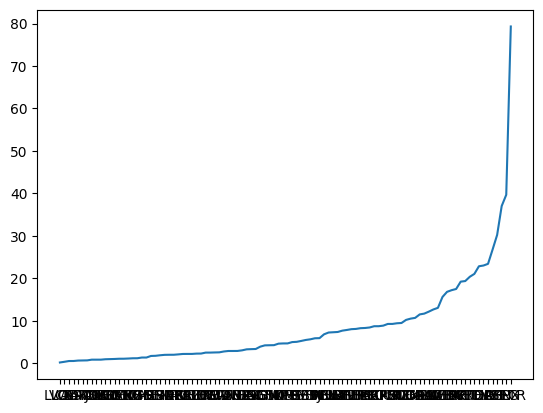

In [ ]:
#Normalise the differences with the maximum distance
wd = []
for i in range(len(tickers)):
    stock = ftse100Market.assets[i]
    realSample = np.array(stocks[tickers[i]]["Price"].diff().dropna()[1:])
    wd.append([wasserstein_distance(u_values=stock.values, v_values=realSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(realSample))/len(realSample)), tickers[i]])

def distSort(e):
    return float(e[0])

wd.sort(key=distSort)
sTickers = []
sDistances = []
for item in wd:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.plot(sTickers, sDistances)
print(sTickers)
print(sDistances)

['LLOY', 'VOD', 'CNA', 'AAF', 'BT-A', 'TSCO', 'TW', 'CTEC', 'BARC', 'JD', 'NWG', 'HLN', 'SBRY', 'MNG', 'LGEN', 'RR', 'MKS', 'KGF', 'AV', 'SMDS', 'GLEN', 'HSBA', 'BME', 'SDR', 'BP', 'FCIT', 'PHNX', 'IAG', 'MRO', 'RTO', 'HWDN', 'BEZ', 'RMV', 'AUTO', 'BA', 'INF', 'BDEV', 'UU', 'STAN', 'SGE', 'LAND', 'FRAS', 'NG', 'RS1', 'PSON', 'SGRO', 'SMT', 'GSK', 'UTG', 'III', 'STJ', 'WPP', 'IMI', 'SSE', 'FRES', 'IMB', 'SMIN', 'SN', 'REL', 'MNDI', 'ANTO', 'BNZL', 'PSH', 'PRU', 'HLMA', 'WEIR', 'ENT', 'SHEL', 'CCH', 'BATS', 'BRBY', 'HIK', 'ADM', 'HL', 'CPG', 'ABF', 'SVT', 'EXPN', 'OCDO', 'DPLM', 'DGE', 'ULVR', 'AAL', 'SKG', 'EDV', 'WTB', 'ITRK', 'AHT', 'RKT', 'BKG', 'DPH', 'RIO', 'DCC', 'IHG', 'CRDA', 'NXT', 'AZN', 'LSEG', 'SPX', 'FLTR']
[0.12228330974807429, 0.24130028360836828, 0.325245896550744, 0.3478280931328508, 0.3965034619018417, 0.4076317527376612, 0.4386221073828928, 0.5060853949334629, 0.513527783063622, 0.5547332675079502, 0.5666797804434324, 0.5826472894199277, 0.6084421909605257, 0.62963496

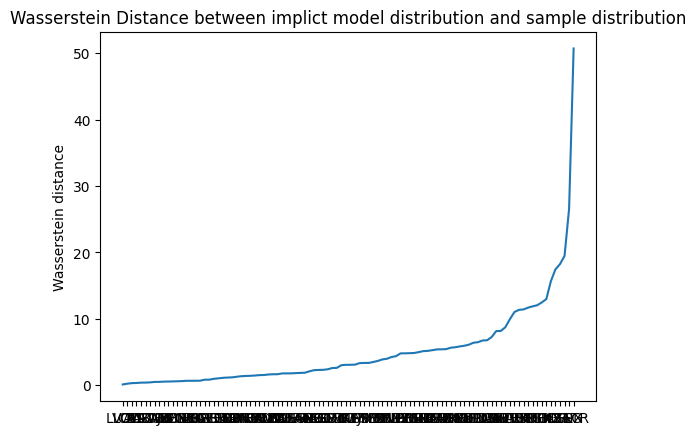

In [ ]:
wd = []
for i in range(len(tickers)):
    stock = ftse100_10jumpMarket.assets[i]
    realSample = np.array(stocks[tickers[i]]["Price"].diff().dropna()[1:])
    wd.append([wasserstein_distance(u_values=stock.values, v_values=realSample, u_weights=stock.probabilities, 
                                   v_weights=np.ones(len(realSample))/len(realSample)), tickers[i]])

#Sort by converting the first element into a float (and then ascending order)
def distSort(e):
    return float(e[0])

wd.sort(key=distSort)
sTickers = []
sDistances = []
for item in wd:
    sTickers.append(item[1])
    sDistances.append(item[0])
    
plt.title("Wasserstein Distance between implict model distribution and sample distribution")
plt.ylabel("Wasserstein distance")
plt.plot(sTickers, sDistances)
print(sTickers)
print(sDistances)

# Current limitations:
- We assume that we can model stock prices such that the increments are stationary.
- No cross vailidation or train/test split
- Quality of fit or statistical significance is missing.
- Comparing variances might be intersting, as well as the ability.
- Find the optimial clusters for clustering.

Todo
- Implement more accurate discrete model (i.e. difference varies dependent current price).
- Look at cross validation for current clustering results
+- Statistical tests - find if any significant, or most accurate models
